In [1]:
clean_up = True
%run stdPackages.ipynb

The file _gams_py_gdb0.gdx is still active and was not deleted.
The file _gams_py_gdb1.gdx is still active and was not deleted.
The file _gams_py_gdb3.gdx is still active and was not deleted.
The file _gams_py_gdb4.gdx is still active and was not deleted.


In [2]:
name = 'A'
db_IO = pyDatabases.GpyDB(f"{d['data']}\\IO_{name}") # load IO database named IO_name
ws = gams.GamsWorkspace(working_directory=d['work']) # specify where you want to run the GAMS models from (here the repository referred to in d['work'])
with open(f"{d['data']}\\glob_{name}","rb") as file: # load global settings anmed glob_name
    glob=pickle.load(file)

In [3]:
def loadFromPickle(x):
    with open(os.path.join(d['data'],x), "rb") as file:
        return pickle.load(file)

### Load modules and run

Load modules:

In [4]:
modules = [name+k for k in ('Pi','Ii','_itory','HH','Trade')]
P = CGE_GmsPython.GmsPython(name = name, glob=glob, m = [loadFromPickle(n) for n in modules], s_kwargs = {'ws': ws})
robust.robust_merge_dbs(P.s.db, db_IO, priority = 'first')

Add equilibrium module:

In [5]:
mEqui = CGE_Equilibrium.Equi(name = name, db_IO = db_IO, glob = glob)
P.addModule(mEqui, merge_s = True)

Set up model, write gams code, and run:

In [6]:
P.compile() # re-compile settings
P.write() # re-write text
m = GmsPy.GmsModel(ws=ws, **{'cns':'CONOPT4'})
checkpoint = m.ws.add_checkpoint()
P.run(model=m, options_run = {'checkpoint': checkpoint})

Increase K0:

In [7]:
m.run(run = f"""tauD.fx[t,s,n]$(sameAs(s,'a') and sameAs(n,'b')) = 0.1; solve {P.s['name']} using CNS;""", options_add = {'checkpoint': checkpoint})
# m.run(run = f"""qD.fx['2016','a','iB'] = 13.5; solve {P.s['name']} using CNS;""", options_add = {'checkpoint': checkpoint})

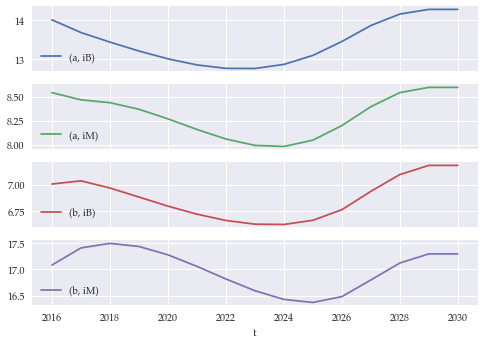

In [14]:
adj.rc_pd(m.out_db.get('qD'), m.out_db.get('dur_p')).unstack('s').unstack('n').plot(subplots=True);

Switch to calibration mode and re-run:

In [9]:
# m.run(run=P.s.writeSolveState('C'), options_add = {'checkpoint': checkpoint})